Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


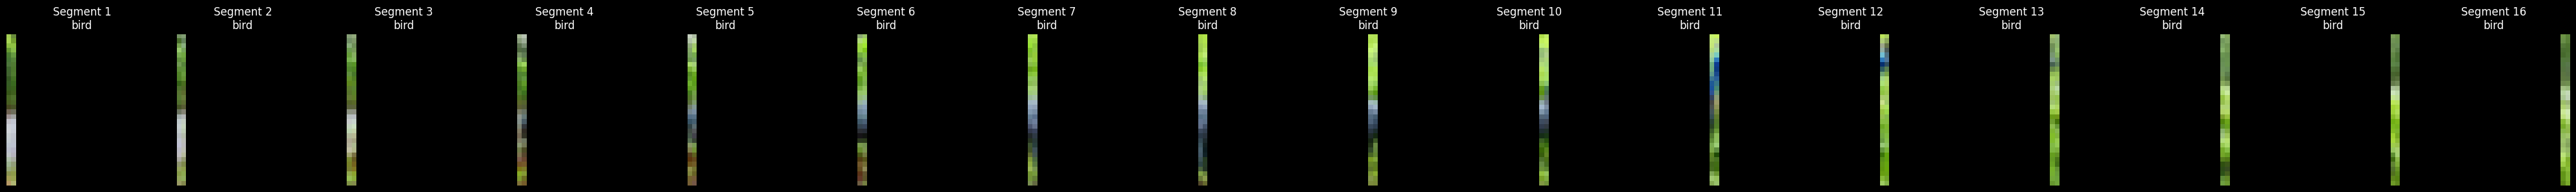

Files already downloaded and verified
Iteration 1
S0 0.1853
S1 0.149
S2 0.2714
S3 0.2116
S4 0.1979
S5 0.2334
S6 0.2168
S7 0.1992
S8 0.2399
S9 0.2011
S10 0.2805
S11 0.2101
S12 0.23
S13 0.155
S14 0.1874
S15 0.1866
AVER 0.1
Iteration 2
S0 0.2484
S1 0.1834
S2 0.1953
S3 0.2448
S4 0.2314
S5 0.2563
S6 0.235
S7 0.2334
S8 0.1859
S9 0.2264


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.multiprocessing import Process, Manager
import copy

# Constants and global settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
ALL_HANDS_ON_DECK = 100


class GridTransform:
    def __init__(self, strip_number):
        self.strip_number = strip_number

    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        blank = torch.zeros_like(tensor)
        slice_height = 32  # CIFAR10 images are 32x32
        slice_width = 32 // 16

        slices = (
            slice(None),
            slice(None),
            slice(
                slice_width * self.strip_number, slice_width * (self.strip_number + 1)
            ),
        )
        blank[slices] = tensor[slices]
        return (blank - 0.5) / 0.5


def create_transform(strip_number):
    return transforms.Compose([GridTransform(strip_number)])


def load_dataset(transform, train=True):
    return torchvision.datasets.CIFAR10(
        root="./data", train=train, download=True, transform=transform
    )


def create_loader(dataset, batch_size=BATCH_SIZE):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)


def show_example_image(*loaders):
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )

    # Get a batch from each loader
    images_list = [next(iter(loader))[0] for loader in loaders]
    labels_list = [next(iter(loader))[1] for loader in loaders]

    # Select a random index from the first batch (assuming all batches are of same length)
    idx = np.random.randint(0, len(images_list[0]))

    # Denormalize the images for display
    def denormalize(img):
        return img * 0.5 + 0.5

    fig, axs = plt.subplots(1, 16, figsize=(40, 40))
    for i, ax in enumerate(axs.flat):
        ax.imshow(denormalize(images_list[i][idx]).numpy().transpose(1, 2, 0))
        ax.set_title(f"Segment {i+1}\n{classes[labels_list[i][idx].item()]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
    )


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Increase from 16 to 64 for CIFAR-10
        self.conv = conv3x3(3, 64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        self.layer3 = self.make_layer(block, 256, layers[2], 2)
        self.layer4 = self.make_layer(block, 512, layers[3], 2)  # Added another layer
        self.avg_pool = nn.AvgPool2d(4)  # Adjust from 8 to 4 for CIFAR-10's 32x32
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Training and testing functions
def test_model(debug_string, model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(debug_string, accuracy)
    return accuracy


def train_model(model, trainloader, optimizer):
    model.train().to(DEVICE)
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def average_weights(*models):
    avg_dict = {
        key: sum([model.state_dict()[key] for model in models]) / len(models)
        for key in models[0].state_dict().keys()
    }
    return avg_dict


def train_one_segment(i, model, trainloader, test_loader, return_dict):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_model(model, trainloader, optimizer)
    accuracy = test_model(f"R{i//4}C{i%4}", model, test_loader)
    return_dict[i] = {"model_state_dict": model.state_dict(), "accuracy": accuracy}


def federated_learning(original_model, trainloaders):
    loaders = trainloaders
    labels = [f"S{i}" for i in range(16)]
    history = []

    models = [copy.deepcopy(original_model).to(DEVICE) for _ in loaders]
    optimizers = [optim.Adam(model.parameters(), lr=LEARNING_RATE) for model in models]

    for model, loader, label in zip(models, loaders, labels):
        train_model(model, loader, optimizers[models.index(model)])
        accuracy = test_model(label, model, test_loader)
        history.append(accuracy)

    avg_state_dict = average_weights(*models)
    new_model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(DEVICE)
    new_model.load_state_dict(avg_state_dict)
    return new_model, history


if __name__ == "__main__":
    # Data Preparation
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # Load datasets for each of the 16 segments
    trainsets = [load_dataset(create_transform(i)) for i in range(16)]
    trainloaders = [create_loader(trainset) for trainset in trainsets]

    show_example_image(*trainloaders)

    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

    # Initialize Model and Criterion
    model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    # Training and Testing - Adjust histories for 16 segments
    histories = [[] for _ in range(16)]
    avg_history = []

    for i in range(ALL_HANDS_ON_DECK):
        print(f"Iteration {i+1}")
        model, local_histories = federated_learning(model, trainloaders)
        for h, local_h in zip(histories, local_histories):
            h.append(local_h)
        # test the averaged model
        avg_history.append(test_model(f"AVER", model, test_loader))

    # Set up a list of labels for the 16 learners
    learner_labels = [f"Learner {i+1}" for i in range(16)]

    # Plot Results for the 16 segments
    for history, label in zip(histories, learner_labels):
        plt.plot(history, label=label)

    # Also plot the avg_history
    plt.plot(avg_history, label="avg", linestyle="--", color="black")

    plt.legend()
    plt.xlabel("Federations")
    plt.ylabel("Accuracy")
    plt.title("Project Malmantile 4x4")

    plt.show()

    # Save Model
    torch.save(model.state_dict(), "malmantile.ckpt")
